#Colab 5: Learn to use Spark's GraphFrames

## Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [6]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install graphframes

!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar

  Using cached https://files.pythonhosted.org/packages/45/b0/9d6860891ab14a39d4bddf80ba26ce51c2f9dc4805e5c6978ac0472c120a/pyspark-3.1.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/9e/b6/6a4fb90cd235dc8e265a6a2067f2a2c99f0d91787f06aca4bcf7c23f3f80/py4j-0.10.9-py2.py3-none-any.whl
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=5cb8972304c78aeb4fe8c7bacd79c331765354e08d3f9b7b11b5197615c3130d
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  242k  100  242k    0 

Now we authenticate a Google Drive client to download files. Please follow the instruction to enter the authoriztion code.


In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now download the file we will be processing in our Spark job.

In [8]:
id='1MnfrYQJtV1p0Iv2xl5qV8QoJY7y_Ozj5'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('metro.csv') 

id='19UgCueFvH4agly8ks0TPzIxIhOWDmh4m'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('country.csv') 

id='1pBOY2eVrFFI2FXQY4ctajYVr1ubfFWoZ'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('continent.csv') 

id='1OkJa_O3G6KgcMq8uCuy9hvoTidjkMCLx'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('metro_country.csv') 

id='1MCrV5XNjlr4X9TJXZV_6RkqGZ9yFZY7w'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('country_continent.csv') 

Import libraries.

In [9]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from graphframes import *


Initialize the Spark context.


In [10]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
try:
  sc.stop()
  sc = pyspark.SparkContext(conf=conf)

except:
  sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


##Load the data## 
The contents in these five input files are pretty straightforward. `metro.csv` has all the cities intormation. `country.csv` has all the countries informaiton. `continent.csv` has all the continents information. `metro_country.csv` builds connection between cities and countier. `country_continent.csv` builds connection between countries and continents.

In [11]:
metro = spark.read.csv("metro.csv", header='true').withColumnRenamed("name","metro_name")
country = spark.read.csv("country.csv", header='true').withColumnRenamed("name","country_name")
continent = spark.read.csv("continent.csv", header='true').withColumnRenamed("name","continent_name")
metro_country = spark.read.csv("metro_country.csv", header='true')
country_continent = spark.read.csv("country_continent.csv", header='true')




In [12]:
# look at the heads

[print(row) for row in metro.head(3)]
[print(row) for row in country.head(3)]
[print(row) for row in continent.head(3)]
[print(row) for row in metro_country.head(3)]
[print(row) for row in country_continent.head(3)]


Row(metro_id='1', metro_name='Tokyo', population='36923000')
Row(metro_id='2', metro_name='Seoul', population='25620000')
Row(metro_id='3', metro_name='Shanghai', population='24750000')
Row(country_id='1', country_name='Japan')
Row(country_id='2', country_name='South Korea')
Row(country_id='3', country_name='China')
Row(continent_id='1', continent_name='Asia')
Row(continent_id='2', continent_name='Africa')
Row(continent_id='3', continent_name='North America')
Row(metro_id='1', country_id='1')
Row(metro_id='2', country_id='2')
Row(metro_id='3', country_id='3')
Row(country_id='1', continent_id='1')
Row(country_id='2', continent_id='1')
Row(country_id='3', continent_id='1')


[None, None, None]

##Task 1##

The goal of this assignment is to learn Spark's graphframes to build graphs and do some simple queires to the graphs. Here are some references you may use:

*   https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html
*   https://towardsdatascience.com/graphframes-in-jupyter-a-practical-guide-9b3b346cebc5
*   https://www.baeldung.com/spark-graph-graphframes

The first task of this assignment to build a graph to show the relationship between countries and metro cities. You should use one graph to show all the countries and all the metro cities in each country.

## 

In [160]:
mc_vertices = metro.join(metro_country, 'metro_id')
mc_vertices = mc_vertices.join(country,'country_id')
mc_vertices = mc_vertices.withColumn('id', concat(mc_vertices['metro_name'],mc_vertices['country_name']) )
temp = metro_country.join(mc_vertices, 'metro_id')
temp = temp.withColumn('src', col('country_name'))

temp = temp.withColumn('dst', col('id'))
temp.head(3)
mc_edges = temp[['src', 'dst']]
mc_edges.head(3)

[Row(src='Japan', dst='TokyoJapan'),
 Row(src='South Korea', dst='SeoulSouth Korea'),
 Row(src='China', dst='ShanghaiChina')]

In [161]:




mc = GraphFrame(mc_vertices, mc_edges)
mc

GraphFrame(v:[id: string, country_id: string ... 4 more fields], e:[src: string, dst: string])

Let's verify the above grpah by checking the outdegrees of vertices. I defined my graph as a directed graph, i.e., a country node has outlinkes to cities. Since cities do not have any outgoinng links, when we check the outdegree, cities are not listed.

In [162]:
out_degrees=mc.outDegrees
out_degrees.show(100)

+--------------+---------+
|            id|outDegree|
+--------------+---------+
|   Philippines|        1|
|     Singapore|        1|
|        Turkey|        2|
|       Germany|        5|
|        France|        1|
|        Taiwan|        1|
|     Argentina|        1|
|        Angola|        1|
|          Peru|        1|
|         China|        5|
|         India|        9|
| United States|       14|
|         Chile|        1|
|       Nigeria|        1|
|         Italy|        2|
|         Spain|        2|
|    Bangladesh|        1|
|          Iran|        1|
|      Thailand|        1|
|   South Korea|        1|
|        Mexico|        1|
|     Indonesia|        1|
|        Canada|        1|
|        Brazil|        3|
|         Japan|        3|
|     Australia|        2|
|      Colombia|        1|
|United Kingdom|        1|
+--------------+---------+



Once you have succesfully created a graphframe, you can use `networkx` to display the graph. In the code below, I assumed `mc` is the graphframe you have created. In this graph, the vertices includes all the coutnries and all the metro cities, and there's an edge between a city and a country if the city is in that country. Overall the graph is a little messy, because there are too many vertices and it is hard to tell which country includes which cities.

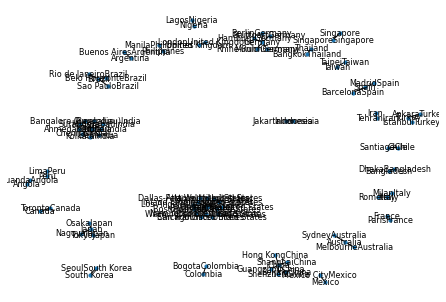

In [163]:
import networkx as nx

mc_gp = nx.from_pandas_edgelist(mc.edges.toPandas(),'src','dst')
nx.draw(mc_gp, with_labels = True, node_size = 10, font_size =8 )

*To* be more focus, let's retrive a subgraph from the above graph. In this subgraph we only want to find out the cities in the USA. This time the graph is easier to read because we don't have many vertices.

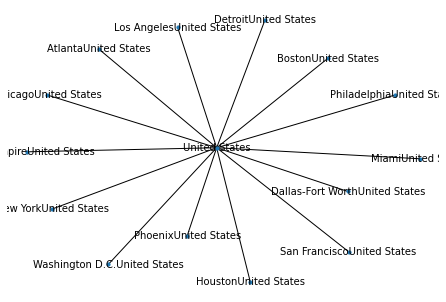

In [164]:
import networkx as nx
american_cities = GraphFrame(mc_vertices.filter("country_name=='United States'"),mc_edges.filter("src=='United States'"))
american_cities_gp = nx.from_pandas_edgelist(american_cities.edges.toPandas(),'src','dst')
nx.draw(american_cities_gp, with_labels = True, node_size = 10, font_size =10 )

##Task 2##
This task is similar to Task 1. The difference is we want to find the relatinship beteen countries and continents. Overall, you should use one graph to include all the continents and the countries should be connected to the continent they belongs to.

In [165]:
# Your code goes here (5 points)

cc_vertices = country.join(country_continent, 'country_id')
cc_vertices = cc_vertices.join(continent,'continent_id')

cc_vertices = cc_vertices.withColumn('id', concat(cc_vertices['country_name'],cc_vertices['continent_name']))

print(cc_vertices.columns)
temp = country_continent.join(cc_vertices, 'country_id')
temp = temp.withColumn('src', col('continent_name'))
temp = temp.withColumn('dst', col('id'))

cc_edges = temp[['src', 'dst']]
cc_edges.head(3)

['continent_id', 'country_id', 'country_name', 'continent_name', 'id']


[Row(src='Asia', dst='JapanAsia'),
 Row(src='Asia', dst='South KoreaAsia'),
 Row(src='Asia', dst='ChinaAsia')]

In [166]:
cc = GraphFrame(cc_vertices, cc_edges)

Let's display the graph.*italicized text*

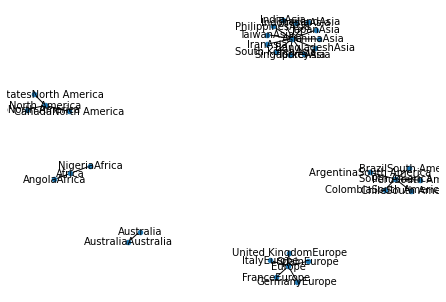

In [167]:
cc_gp = nx.from_pandas_edgelist(cc.edges.toPandas(),'src','dst')
nx.draw(cc_gp, with_labels = True, node_size = 20, font_size = 10)

Again, let's only focus on Continent "North America" only to make the graph easy to read.

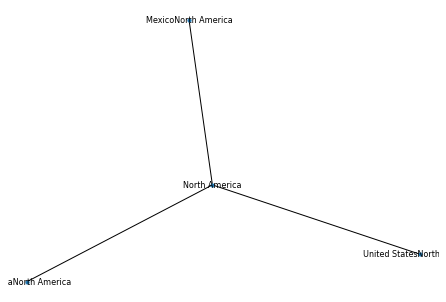

In [168]:
North_American_countires = GraphFrame(cc_vertices.filter("continent_name=='North America'"),cc_edges.filter("src=='North America'"))
na_countires = nx.from_pandas_edgelist(North_American_countires.edges.toPandas(),'src','dst')
nx.draw(na_countires, with_labels = True, node_size = 10, font_size =8 )



##Task 3##

Put it all together. Now you should build a grpah which shows all the continents, all the countries and all the metro cities. Link them accordingly based on their geographical locations. This graph is even messier because it has too many vertices.

[Row(country_name='Japan', metro_id='1', metro_name='Tokyo', population='36923000', continent_id='1', continent_name='Asia', id='TokyoJapanAsia')]
+------------------+--------------------+
|               src|                 dst|
+------------------+--------------------+
|             Japan|          TokyoJapan|
|       South Korea|    SeoulSouth Korea|
|             China|       ShanghaiChina|
|             China|      GuangzhouChina|
|             India|          DelhiIndia|
|            Mexico|   Mexico CityMexico|
|             China|        BeijingChina|
|           Nigeria|        LagosNigeria|
|            Brazil|     Sao PauloBrazil|
|             India|         MumbaiIndia|
|     United States|New YorkUnited St...|
|             Japan|          OsakaJapan|
|        Bangladesh|     DhakaBangladesh|
|             India|        KolkataIndia|
|              Iran|          TehranIran|
|            Turkey|      IstanbulTurkey|
|    United Kingdom|LondonUnited Kingdom|
|     United 

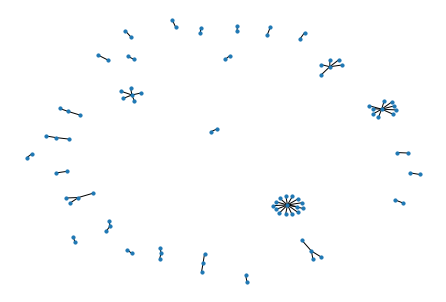

In [204]:
mcc_vertices = mc_vertices.join(cc_vertices, 'country_name')
# drop the redunent id. 
# id needs to be cityCountryContinent
mcc_vertices = mcc_vertices.drop('id')

mcc_vertices = mcc_vertices.withColumn('id', concat(mcc_vertices['metro_name'],mcc_vertices['country_name'],mcc_vertices['continent_name']))

# mcc_vertices.head(4)
# print('cc')
# print(cc_edges.head(1))
# print('mcc')
# print(mc_edges.head(1))

#### YOU NEED TO AMEK MC_EDGES.SCR BE THE .CONTAINS OF CC.SOURCE. 

# USE CONCAT FROM MCC_VERTICES. 
temp = mcc_vertices[['metro_name', 'country_name','continent_name']]                    
temp_cc_edges = cc_edges.withColumnRenamed('src', 'country_name')
s = temp.join(temp_cc_edges, 'country_name' )

s = s.withColumn('src', concat(s['country_name'],s['continent_name']))
s = s.withColumn('dst', concat(s['metro_name'],s['country_name'],s['continent_name']))


cc_edges_two = s['src', 'dst']


# print('after transform')
# print('cc')
# print(cc_edges.head(1))
# print('mcc')
# print(mc_edges_two.head(1))

mcc_edges= mc_edges.union(cc_edges_two)

## remove duplicate coutnry id from mmc_vertices

mcc_vertices = mcc_vertices.drop('country_id')

mcc = GraphFrame(mcc_vertices, mcc_edges)

print(mcc.vertices.head(1))
whole_graph = nx.from_pandas_edgelist(mcc.edges.toPandas(),'src','dst')
nx.draw(whole_graph, with_labels = False, node_size = 10, font_size =8)

mcc.edges.show(500)


The graph you built above has several connected components (i.e., continents). Now let's use graphframe's `conectedComponents()` to find each individual component. 

In [205]:
sc.setCheckpointDir("/tmp/graphframes-example-connected-components")
components = mcc.connectedComponents()

In [206]:
components.show(100)

+--------------+--------+--------------------+----------+------------+--------------+--------------------+-------------+
|  country_name|metro_id|          metro_name|population|continent_id|continent_name|                  id|    component|
+--------------+--------+--------------------+----------+------------+--------------+--------------------+-------------+
|         Japan|       1|               Tokyo|  36923000|           1|          Asia|      TokyoJapanAsia|   8589934593|
|   South Korea|       2|               Seoul|  25620000|           1|          Asia|SeoulSouth KoreaAsia|1675037245441|
|         China|       3|            Shanghai|  24750000|           1|          Asia|   ShanghaiChinaAsia|1065151889408|
|         China|       4|           Guangzhou|  23900000|           1|          Asia|  GuangzhouChinaAsia| 103079215104|
|         India|       5|               Delhi|  21753486|           1|          Asia|      DelhiIndiaAsia|1675037245440|
|        Mexico|       6|       

Once we know such informaiton, we only want to display one conneted component, which is Continent "North America", i.e., display all the contries in North America, and all the metro cities in these countries.

In [ ]:
# Your code goes here (5 points)
# northamerica_vertices = 
# northamerica_edges = 

In [ ]:
northamerica = GraphFrame(northamerica_vertices, northamerica_edges)

In [ ]:
northamerica_gp = nx.from_pandas_edgelist(northamerica.edges.toPandas(),'src','dst')
nx.draw(northamerica_gp, with_labels = True, node_size = 40, font_size = 10, edge_color = "red")